In [1]:
!unzip clean_data.zip -d data # unzip the downloaded dataset

Archive:  clean_data.zip
replace data/process_data/train/s10/7.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/process_data/train/s10/7.png  
  inflating: data/process_data/train/s10/5.png  
  inflating: data/process_data/train/s10/9.png  
  inflating: data/process_data/train/s10/8.png  
  inflating: data/process_data/train/s10/6.png  
  inflating: data/process_data/train/s10/4.png  
  inflating: data/process_data/train/s10/10.png  
  inflating: data/process_data/train/s28/7.png  
  inflating: data/process_data/train/s28/2.png  
  inflating: data/process_data/train/s28/5.png  
  inflating: data/process_data/train/s28/1.png  
  inflating: data/process_data/train/s28/6.png  
  inflating: data/process_data/train/s28/3.png  
  inflating: data/process_data/train/s28/10.png  
  inflating: data/process_data/train/s24/7.png  
  inflating: data/process_data/train/s24/2.png  
  inflating: data/process_data/train/s24/1.png  
  inflating: data/process_data/train/s24/8.png  
  inflat

In [2]:
import os
import shutil
import random
import numpy as np
import cv2
from PIL import Image


import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow.keras.utils import plot_model

from tensorflow.keras.saving import save_model

print(tf.version.VERSION)


2.12.0


In [3]:
# set the paths to the original and new data directories
original_data_dir = '/content/data/process_data'
train_dir = '/content/data/process_data/train'
test_dir = '/content/data/process_data/test'
valid_dir = '/content/data/process_data/valid'

In [4]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the image height
    shear_range=0.2,  # apply shear transformation with a shear angle of up to 20 degrees
    zoom_range=0.2,  # apply zoom transformation by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any gaps created by the above transformations with the nearest pixel
)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

Found 280 images belonging to 40 classes.
Found 120 images belonging to 40 classes.


In [5]:
# Define the weight decay value
weight_decay = 0.00000

# Create the AlexNet-like model
model = tf.keras.Sequential([
    # Conv1 + Relu with weight decay
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), input_shape=(227, 227, 3), padding='valid',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.ReLU(),
    # Max Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    # Norm
    tf.keras.layers.BatchNormalization(),
    # Conv2 + Relu with weight decay
    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.ReLU(),
    # Max Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    # Norm
    tf.keras.layers.BatchNormalization(),
    # Conv3 + Relu with weight decay
    tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.ReLU(),
    # Conv4 + Relu with weight decay
    tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.ReLU(),
    # Conv5 + Relu with weight decay
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.ReLU(),
    # Max Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    # Flatten
    tf.keras.layers.Flatten(),
    # FC6 + Relu with weight decay
    tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    # Dropout
    tf.keras.layers.Dropout(0.5),
    # FC7 + Relu with weight decay
    tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    # Dropout
    tf.keras.layers.Dropout(0.5),
    # FC8 + Softmax with weight decay
    tf.keras.layers.Dense(40, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay))
])

# Optimizer with initial learning rate of 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.09)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 re_lu (ReLU)                (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 re_lu_1 (ReLU)              (None, 27, 27, 256)       0

In [6]:

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # specify the number of epochs for training
    validation_data=val_generator
)

Epoch 1/20
5/5 [==============================] - 63s 12s/step - loss: 3.9681 - accuracy: 0.0286 - val_loss: 3.6888 - val_accuracy: 0.0250
Epoch 2/20
5/5 [==============================] - 55s 11s/step - loss: 3.9732 - accuracy: 0.0143 - val_loss: 3.6884 - val_accuracy: 0.0333
Epoch 3/20
5/5 [==============================] - 59s 13s/step - loss: 3.9091 - accuracy: 0.0321 - val_loss: 3.6885 - val_accuracy: 0.0500
Epoch 4/20
5/5 [==============================] - 55s 12s/step - loss: 3.8744 - accuracy: 0.0214 - val_loss: 3.6885 - val_accuracy: 0.0417
Epoch 5/20
5/5 [==============================] - 59s 12s/step - loss: 3.8646 - accuracy: 0.0321 - val_loss: 3.6883 - val_accuracy: 0.0167
Epoch 6/20
5/5 [==============================] - 54s 11s/step - loss: 3.7722 - accuracy: 0.0286 - val_loss: 3.6875 - val_accuracy: 0.0417
Epoch 7/20
5/5 [==============================] - 59s 12s/step - loss: 3.7912 - accuracy: 0.0143 - val_loss: 3.6868 - val_accuracy: 0.0417
Epoch 8/20
5/5 [===========

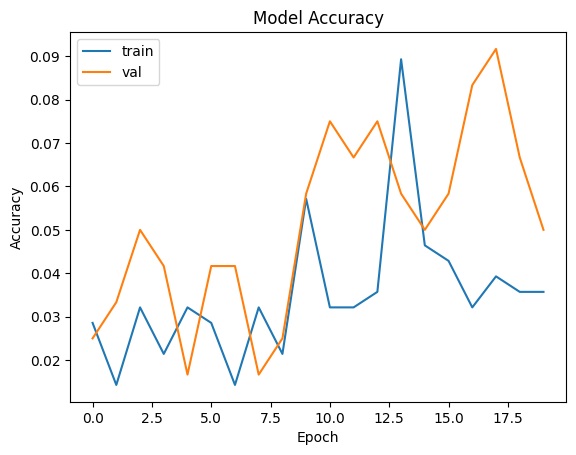

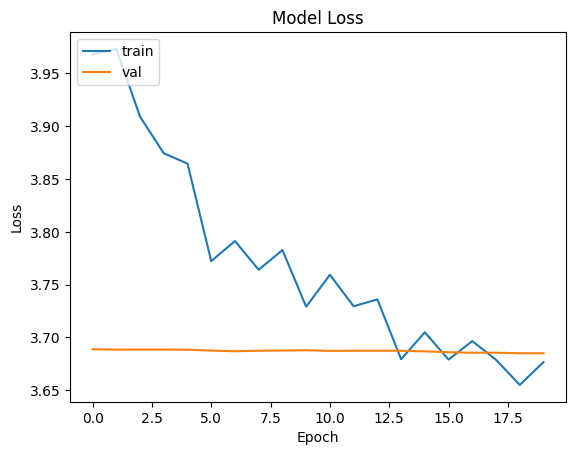

In [7]:

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [8]:
filepath = '/content/models/Alexnet'

save_model(
    model, filepath, overwrite=True, save_format=None
)

In [9]:

# Load VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False)

# Add top layers
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(4096, activation='relu')(x1) # Keep the fully connected layer with 4096 units
x3 = Dense(4096, activation='relu')(x2) # Keep the fully connected layer with 4096 units
predictions = Dense(40, activation='softmax')(x3) # Change to 40 units for 40-class classifier

# Create a new model with the added top layers
model_1 = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [10]:
# Train the model
history_1 = model_1.fit(
    train_generator,
    epochs=10,  # specify the number of epochs for training
    validation_data=val_generator
)

Epoch 1/10
5/5 [==============================] - 371s 86s/step - loss: 4.9513 - accuracy: 0.0071 - val_loss: 3.7194 - val_accuracy: 0.0250
Epoch 2/10
5/5 [==============================] - 306s 64s/step - loss: 3.7290 - accuracy: 0.0179 - val_loss: 3.6836 - val_accuracy: 0.0750
Epoch 3/10
5/5 [==============================] - 356s 76s/step - loss: 3.6889 - accuracy: 0.0357 - val_loss: 3.6656 - val_accuracy: 0.0250
Epoch 4/10
5/5 [==============================] - 356s 84s/step - loss: 3.6694 - accuracy: 0.0321 - val_loss: 3.6412 - val_accuracy: 0.0500
Epoch 5/10
5/5 [==============================] - 356s 77s/step - loss: 3.6270 - accuracy: 0.0786 - val_loss: 3.5849 - val_accuracy: 0.1167
Epoch 6/10
5/5 [==============================] - 356s 84s/step - loss: 3.5569 - accuracy: 0.0929 - val_loss: 3.4774 - val_accuracy: 0.1500
Epoch 7/10
5/5 [==============================] - 357s 77s/step - loss: 3.4466 - accuracy: 0.1143 - val_loss: 3.3267 - val_accuracy: 0.1417
Epoch 8/10
5/5 [====

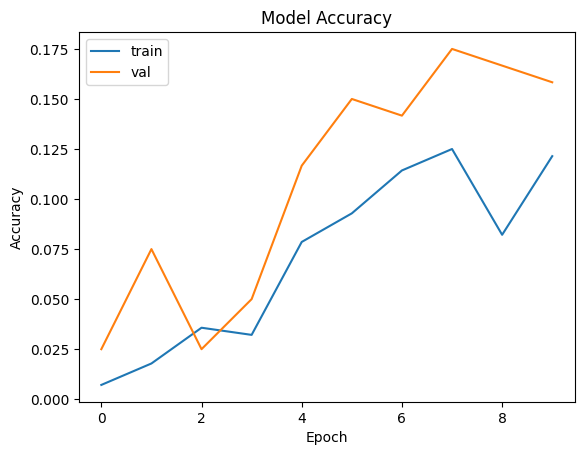

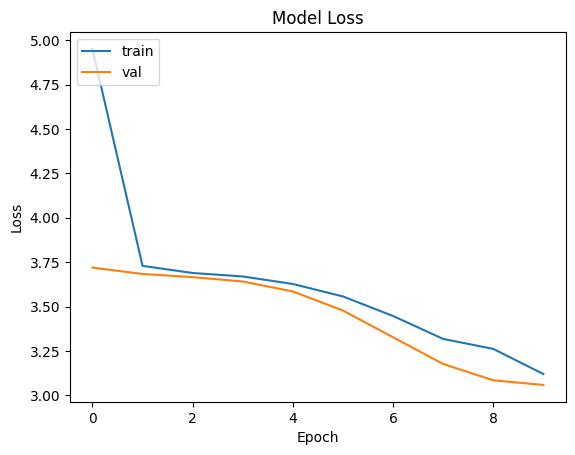

In [11]:
# Plot the training and validation accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [12]:
filepath = '/content/models/VGG19'

save_model(
    model, filepath, overwrite=True, save_format=None
)

In [14]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/Alexnet/ (stored 0%)
  adding: models/Alexnet/keras_metadata.pb (deflated 93%)
  adding: models/Alexnet/variables/ (stored 0%)
  adding: models/Alexnet/variables/variables.index (deflated 65%)
  adding: models/Alexnet/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: models/Alexnet/saved_model.pb (deflated 89%)
  adding: models/Alexnet/assets/ (stored 0%)
  adding: models/Alexnet/fingerprint.pb (stored 0%)
  adding: models/VGG19/ (stored 0%)
  adding: models/VGG19/keras_metadata.pb (deflated 93%)
  adding: models/VGG19/variables/ (stored 0%)
  adding: models/VGG19/variables/variables.index (deflated 65%)
  adding: models/VGG19/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: models/VGG19/saved_model.pb (deflated 89%)
  adding: models/VGG19/assets/ (stored 0%)
  adding: models/VGG19/fingerprint.pb (stored 0%)
